In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [ ]:
# 1. Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
data = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])

# 2. Feature-Engineering
# Berechnung der durchschnittlichen Ladeleistung
data['averageChargingPower'] = data['kWhDelivered'] / ((data['disconnectTime'] - data['connectionTime']).dt.total_seconds() / 3600)
data['hourOfDay'] = data['connectionTime'].dt.hour  # Stunde des Tages aus connectionTime

# Berechnung der Standortauslastung
occupancy = []
for index, row in data.iterrows():
    count = data[(data['siteID'] == row['siteID']) &
                 (data['connectionTime'] <= row['disconnectTime']) &
                 (data['disconnectTime'] >= row['connectionTime'])].shape[0]
    occupancy.append(count)
data['siteOccupancy'] = occupancy

data = data.dropna(subset=['hourOfDay', 'averageChargingPower', 'siteID', 'siteOccupancy'])



ARIMA-Analyse für SiteID=1

Zielvariable: Charging Power
Mean Squared Error (MSE) für Charging Power: 0.1201


C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


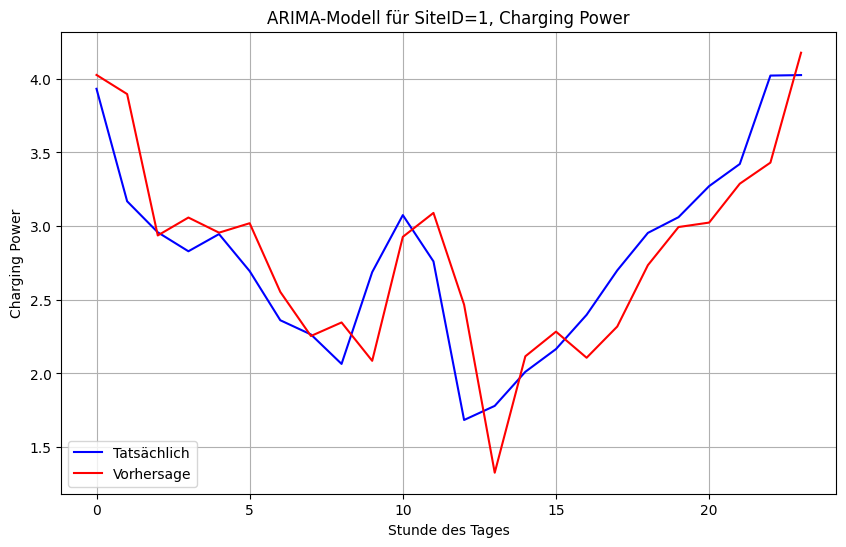


Zielvariable: Site Occupancy
Mean Squared Error (MSE) für Site Occupancy: 57.1215


C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


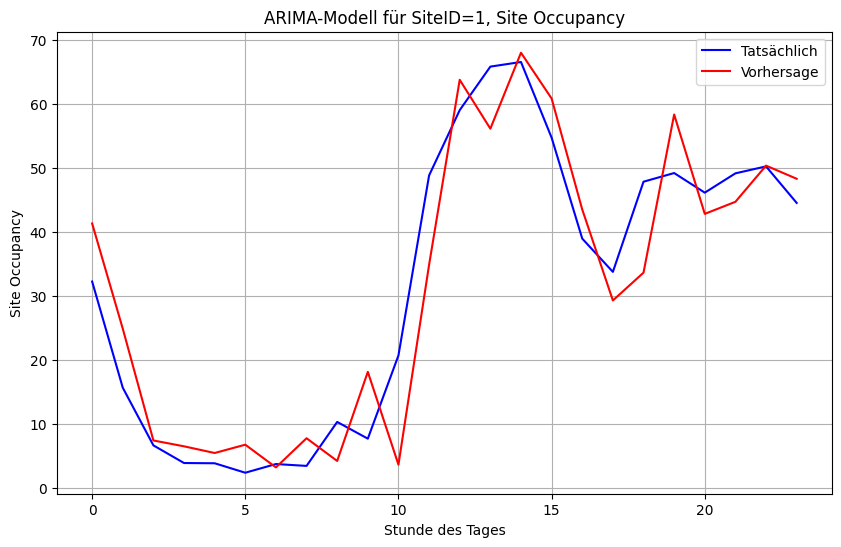


ARIMA-Analyse für SiteID=2

Zielvariable: Charging Power
Mean Squared Error (MSE) für Charging Power: 0.9525


C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


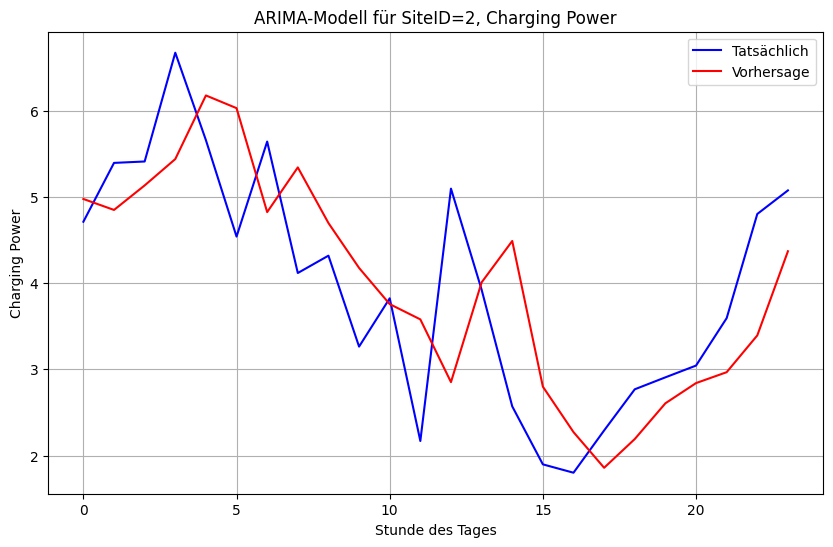


Zielvariable: Site Occupancy


C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Mean Squared Error (MSE) für Site Occupancy: 37.9454


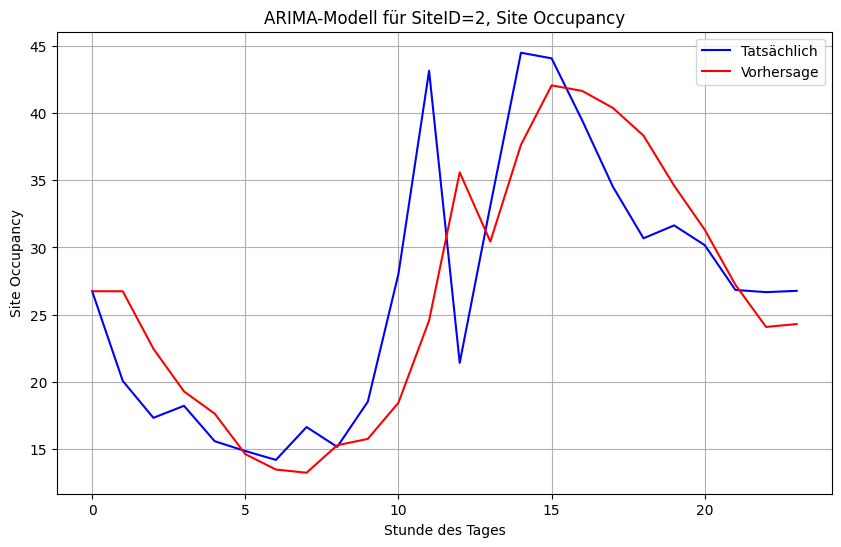

In [12]:
# Analyse für SiteID=1 und SiteID=2
for site in [1, 2]:
    print(f"\nARIMA-Analyse für SiteID={site}")
    site_data = data[data['siteID'] == site]

    for target, target_name in [("averageChargingPower", "Charging Power"), ("siteOccupancy", "Site Occupancy")]:
        print(f"\nZielvariable: {target_name}")

        # 3. Zeitreihe erstellen
        time_series = site_data.groupby('hourOfDay')[target].mean()

        # 4. Zyklisches Padding der Zeitreihe
        padded_series = pd.concat([
            time_series[-2:],  # Letzte zwei Stunden an den Anfang
            time_series,
            time_series[:2]   # Erste zwei Stunden ans Ende
        ])
        padded_index = list(range(-2, 24 + 2))

        # 5. ARIMA-Modell trainieren
        p, d, q = 2, 1, 2  # ARIMA-Hyperparameter (können angepasst werden)
        model = ARIMA(padded_series, order=(p, d, q))
        model_fit = model.fit()

        # 6. Vorhersagen erstellen
        forecast = model_fit.get_prediction(start=2, end=25).predicted_mean  # Vorhersagen für Stunden 0-23

        # 7. Fehler berechnen (Mean Squared Error)
        y_true = time_series  # Tatsächliche Werte
        mse = mean_squared_error(y_true, forecast[:len(y_true)])
        print(f"Mean Squared Error (MSE) für {target_name}: {mse:.4f}")

        # 8. Visualisierung
        plt.figure(figsize=(10, 6))
        plt.plot(time_series.index, time_series, label="Tatsächlich", color="blue")
        plt.plot(time_series.index, forecast[:len(time_series)], label="Vorhersage", color="red")
        plt.xlabel("Stunde des Tages")
        plt.ylabel(target_name)
        plt.title(f"ARIMA-Modell für SiteID={site}, {target_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Ergebnisse speichern
        results = pd.DataFrame({"HourOfDay": time_series.index,
                                "Actual": time_series.values,
                                "Forecast": forecast[:len(time_series)]})
        results.to_csv(f"arima_results_site{site}_{target_name.lower().replace(' ', '_')}.csv", index=False)
